In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import display

In [2]:
dfs = pd.read_excel("clinical data.xlsx", sheet_name=None)
dfs = [dfs[key] for key in dfs.keys()]

SIZES = list(map(lambda x: int(x.split()[0]), dfs[0].columns))
COLORS = mpl.colormaps["viridis"](np.linspace(0.8,0.2,5))

display(dfs[0].head())
display(dfs[1].head())

,30 um CSC (mC/cm^2),50 um CSC (mC/cm^2),100 um CSC (mC/cm^2),150 um CSC (mC/cm^2),200 um CSC (mC/cm^2)
0,20.3,22.3,25.8,30.7,40.3
1,21.4,21.8,28.6,33.5,45.8
2,17.8,23.7,30.8,29.9,48.9
3,19.5,19.9,27.5,34.2,47.8
4,18.2,26.7,22.5,36.8,50.3


,Sex,Device Type,RR Before Stim (breaths/min),RR After Stim (breaths/min)
0,M,30 um,12.4,13.2
1,M,30 um,14.6,14.5
2,M,30 um,13.8,15.3
3,F,30 um,20.4,20.5
4,M,30 um,19.5,19.3


# Charge storage capacity (CSC) data analysis

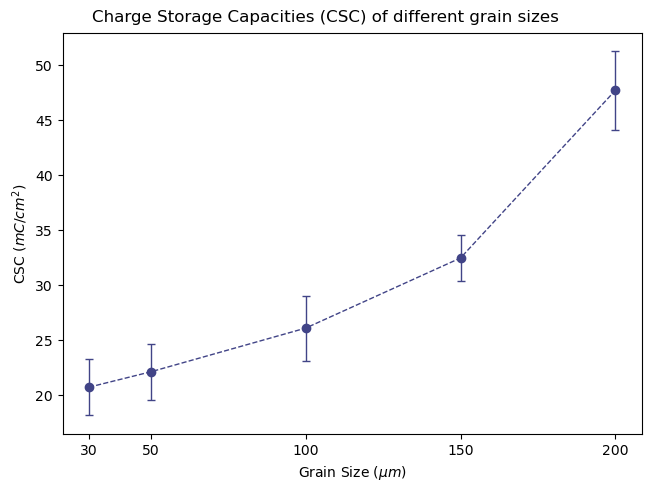

In [3]:
fig = plt.figure(layout='constrained')
ax = fig.subplots()

plt.errorbar(SIZES, dfs[0].mean(), yerr=dfs[0].std(), fmt="o--", color=COLORS[-1], linewidth=1, capsize=3)

ax.set_xticks(SIZES)
plt.xlabel(r"Grain Size ($\mu m $)")
plt.ylabel(r"CSC ($mC / cm^2$)")
plt.suptitle("Charge Storage Capacities (CSC) of different grain sizes")

plt.show()

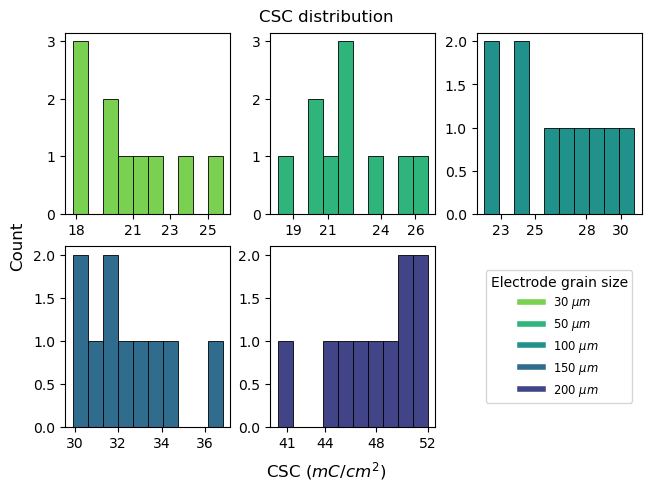

In [17]:
# fig, ax = plt.subplots(2, 3, constrained_layout=True)
# ax[-1,-1].remove()
# dfs[0].hist(color=COLORS[1], edgecolor="black", linewidth=0.6, grid=False, ax=ax.ravel()[:5])
# plt.show()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(5):
    ax = axs[i//3, i%3]
    ax.set_xticks([*map(int, np.linspace(min(dfs[0].iloc[:,i])+1, max(dfs[0].iloc[:,i]), 4))])
    dfs[0].iloc[:,i].hist(color=COLORS[i], edgecolor="black", linewidth=0.6, grid=False, ax=ax)

axs[-1,-1].legend(handles=[mpl.lines.Line2D([0], [0], color=COLORS[i], lw=4) for i in range(5)],
                  labels=[f"{s} " + r"$\mu m$" for s in SIZES],
                  title="Electrode grain size", loc='center', fontsize='small')

axs[-1,-1].axis('off')
plt.suptitle("CSC distribution")
fig.supxlabel(r"CSC ($mC/cm^2$)")
fig.supylabel("Count")
plt.show()

In [5]:
for s in SIZES:
    print(f'{s} um results:',stats.shapiro(dfs[0][f'{s} um CSC (mC/cm^2)']))

30 um results: ShapiroResult(statistic=0.9328032026562041, pvalue=0.476024092422507)
50 um results: ShapiroResult(statistic=0.9760439838911069, pvalue=0.9405473935027514)
100 um results: ShapiroResult(statistic=0.9655971797048837, pvalue=0.8472958347825618)
150 um results: ShapiroResult(statistic=0.9451249190117598, pvalue=0.6113102692071415)
200 um results: ShapiroResult(statistic=0.9362101152731511, pvalue=0.5116626187473816)


In [6]:
# Normal ANOVA since data is normally dsitributed
stats.f_oneway(*[dfs[0][f'{s} um CSC (mC/cm^2)'] for s in SIZES])

F_onewayResult(statistic=154.68559817778555, pvalue=1.1071633494384018e-25)

In [7]:
#Post-hoc test - Bonferroni Correction
ca = 0.05/(len(SIZES) * (len(SIZES) - 1) / 2)
print('Corrected alpha: ', ca)

for s1 in SIZES:
    for s2 in SIZES:
        if s1 >= s2: continue
        ttest = stats.ttest_ind(dfs[0][f'{s1} um CSC (mC/cm^2)'], dfs[0][f'{s2} um CSC (mC/cm^2)'])
        if ttest.pvalue < ca:
            print(f'{s1} to {s2} um:', ttest)

Corrected alpha:  0.005
30 to 100 um: TtestResult(statistic=-4.335205691273846, pvalue=0.00039874090748587927, df=18.0)
30 to 150 um: TtestResult(statistic=-11.278270467655549, pvalue=1.360688514765877e-09, df=18.0)
30 to 200 um: TtestResult(statistic=-19.327223580439796, pvalue=1.737422006649516e-13, df=18.0)
50 to 100 um: TtestResult(statistic=-3.2115027875604283, pvalue=0.004838547495565712, df=18.0)
50 to 150 um: TtestResult(statistic=-9.9619759760067, pvalue=9.469903375221132e-09, df=18.0)
50 to 200 um: TtestResult(statistic=-18.353302859444454, pvalue=4.2222524230316623e-13, df=18.0)
100 to 150 um: TtestResult(statistic=-5.597274462202518, pvalue=2.597690403472827e-05, df=18.0)
100 to 200 um: TtestResult(statistic=-14.700795652942427, pvalue=1.8049759788069715e-11, df=18.0)
150 to 200 um: TtestResult(statistic=-11.653299469182894, pvalue=8.078442433116009e-10, df=18.0)


$\Rightarrow$ All devices axcept 30 and 50 are different from eachother

# Respiratory rate (RR) data analysis

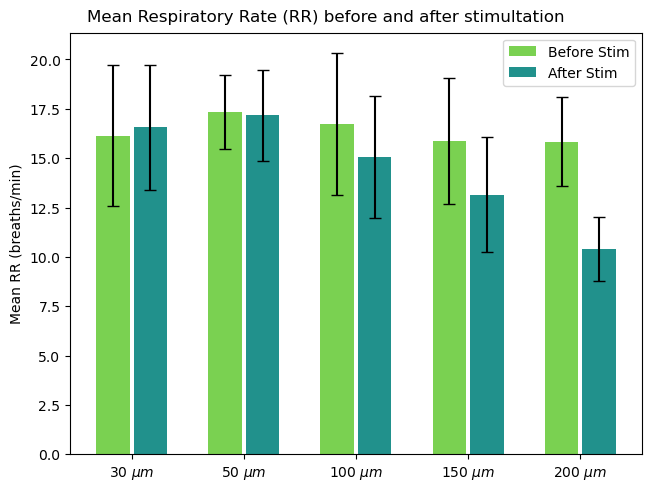

In [8]:
fig = plt.figure(layout='constrained')

means = np.array([
    dfs[1][['RR Before Stim (breaths/min)','RR After Stim (breaths/min)']]
    [dfs[1]['Device Type'] == f"{s} um"].mean() for s in SIZES
]).flatten()

stds = np.array([
    dfs[1][['RR Before Stim (breaths/min)','RR After Stim (breaths/min)']]
    [dfs[1]['Device Type'] == f"{s} um"].std() for s in SIZES
]).flatten()

plt.bar(range(1,15,3), means[::2], 
        yerr=stds[::2], color=COLORS[0], capsize=4, width=0.9)
plt.bar(range(2,15,3), means[1::2], 
        yerr=stds[1::2], color=COLORS[2], capsize=4, width=0.9)
plt.legend(['Before Stim','After Stim'])

plt.ylabel(r"Mean RR (breaths/min)")
plt.xticks(np.arange(1.5, 14, 3),[f'{s} ' + r"$\mu m$" for s in SIZES])
plt.suptitle("Mean Respiratory Rate (RR) before and after stimultation")

plt.show()

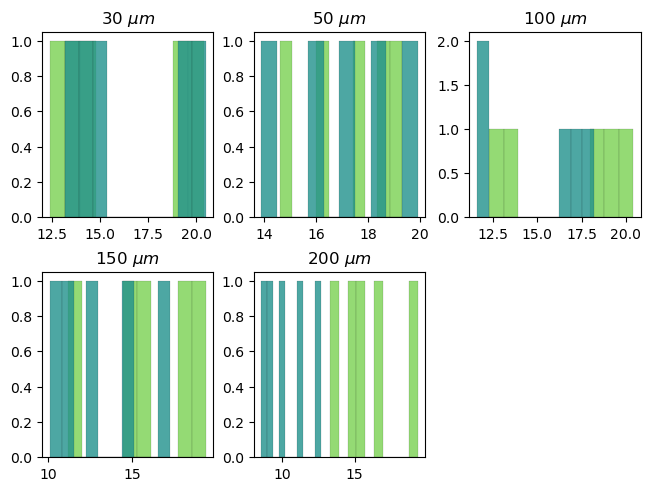

In [9]:
fig, axs = plt.subplots(2, 3, layout="constrained")
axs[-1,-1].remove()
axs = axs.ravel()
for i, s in enumerate(SIZES):
    axs[i].hist(dfs[1]['RR Before Stim (breaths/min)'][dfs[1]['Device Type'] == f'{s} um'], edgecolor="black", alpha=0.8, linewidth=0.1, color=COLORS[0])
    axs[i].hist(dfs[1]['RR After Stim (breaths/min)'][dfs[1]['Device Type'] == f'{s} um'], edgecolor="black", alpha=0.8, linewidth=0.1, color=COLORS[2])
    axs[i].title.set_text(f"{s} " + r"$\mu m$")

plt.show()

5 samples per electrode is not enough to determine normality. Therfore, we use a Wilcoxon statistic

In [10]:
for s in SIZES:
    print(f"{s} um", stats.wilcoxon(dfs[1]['RR Before Stim (breaths/min)'][dfs[1]['Device Type'] == f'{s} um'],
              dfs[1]['RR After Stim (breaths/min)'][dfs[1]['Device Type'] == f'{s} um']))

30 um WilcoxonResult(statistic=4.0, pvalue=0.4375)
50 um WilcoxonResult(statistic=3.0, pvalue=0.4652088184521418)
100 um WilcoxonResult(statistic=0.0, pvalue=0.0625)
150 um WilcoxonResult(statistic=0.0, pvalue=0.0625)
200 um WilcoxonResult(statistic=0.0, pvalue=0.0625)


/nix/store/1nznx3yrv1lz0r1z49mwxxqjsfzikdrw-python3.12-scipy-1.14.0/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


$\Rightarrow$ All devices except 30 and 50 are different from eachother